# Clasificación de Imágenes de Animales usando Apache Spark MLlib

## Introducción
Este notebook implementa un modelo de clasificación de imágenes utilizando Apache Spark MLlib para categorizar diferentes especies de animales. El dataset originalmente contenía 64 categorías diferentes de animales, con un mínimo de 216 imágenes por categoría. Para el alcance de este proyecto y por las limitaciones que tiene la herramienta de colab, se usaran solamente 200 fotos de 15 categorías de animales. Lo determiné de esta manera porque al intentar utilizar el dataset completo, era imposible terminar de siquiera procesar las imágenes por la cantidad de RAM que ocupa el procesamiento.

En razón de cumplir con las específicaciones de mi profesor para esta actividad, con respecto a que el dataset tiene que ser mayor a un giga, las imágenes utilizadas pesan 400-600 kb. Si se hace la cuenta de las 3000 imágenes utilizadas tomando la media de 500 kb, si se hace el calculo, estoy utilizando en total 1.5 gigas de datos. Siendo esto suficiente para cumplir con los requerimientos del profesor.

### Características del Proyecto:
- **Framework**: Apache Spark MLlib
- **Tipo de Modelo**: Clasificación Multiclase
- **Dataset**: 64 categorías de animales
- **Imágenes por Categoría**: Mínimo 216
- **Algoritmo**: Random Forest Classifier
- **Entorno de Ejecución**: Google Colab con PySpark

### Estructura del Proyecto:
1. Configuración del entorno Spark
2. Preprocesamiento de imágenes
3. Creación del pipeline de datos
4. Entrenamiento del modelo
5. Evaluación y métricas
6. Guardado del modelo

### Link al dataset de Kaggle:
https://www.kaggle.com/datasets/anthonytherrien/image-classification-64-classes-animal
---
**Autor**: Juan Pablo Cabrera  
**Fecha**: 28/10/2025

## Análisis de las 5V de mi Dataset.

En el contexto de Big Data, es crucial analizar las cinco características fundamentales (5 V's) en mi conjunto de datos. En términos de **Volumen**, el dataset cumple ampliamente con este criterio. Originalmente contiene 64 categorías diferentes de animales, cada una con un mínimo de 216 imágenes. Para este proyecto, trabajo con una muestra significativa de 3000 imágenes, distribuidas en 15 categorías con 200 imágenes cada una. Considerando que cada imagen tiene un tamaño entre 400-600 KB, el dataset total alcanza aproximadamente 1.5 GB de datos, un volumen que requiere técnicas específicas de Big Data para su procesamiento eficiente.

En cuanto a la **Velocidad**, aunque en este proyecto trabajo con un conjunto de datos estático, la infraestructura que he implementado utilizando Spark está diseñada para manejar datos a alta velocidad. El framework permite el procesamiento en streaming y podría adaptarse fácilmente para manejar nuevas imágenes en tiempo real, lo que demuestra su capacidad para escalar y procesar datos a diferentes velocidades según las necesidades.

La **Variedad** en mi dataset se manifiesta de múltiples formas. No solo incluye 15 especies diferentes de animales, sino que cada imagen presenta características únicas en términos de ángulos de captura, condiciones de iluminación, fondos y comportamientos de los animales. Esta diversidad en los datos enriquece el dataset y lo hace más representativo de situaciones del mundo real.

La **Veracidad** del dataset está respaldada por varios factores importantes. Las imágenes son fotografías reales de animales, no generadas artificialmente, y provienen de un dataset curado y verificado en Kaggle. La calidad de las etiquetas ha sido validada por la comunidad, y la resolución de las imágenes es suficiente para identificar características distintivas de cada especie. Además, al contar con múltiples imágenes por clase, puedo verificar la consistencia en la clasificación.

Finalmente, en términos de **Valor**, este dataset tiene un potencial significativo. Su aplicación no se limita solo al desarrollo de modelos de clasificación de especies animales; tiene implicaciones importantes para la conservación y el monitoreo de vida silvestre, la investigación en visión por computadora, y aplicaciones educativas sobre diferentes especies animales. El valor se multiplica al considerar que este dataset puede servir como base para desarrollar sistemas más complejos de reconocimiento animal.


# Inicio

In [ ]:
 # Instalación de las dependencias necesarias
!pip install pyspark
!pip install findspark

# Importaciones básicas que necesitaremos
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType, ArrayType
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
from PIL import Image
import numpy as np
from google.colab import drive

# Creación de nuestra sesión Spark
spark = SparkSession.builder \
    .appName("Clasificacion de Imagenes con MLlib") \
    .config("spark.driver.memory", "16g") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.memory.offHeap.enabled", True) \
    .config("spark.memory.offHeap.size", "8g") \
    .config("spark.sql.shuffle.partitions", "10") \
    .config("spark.default.parallelism", "10") \
    .config("spark.driver.extraJavaOptions", "-XX:+UseG1GC") \
    .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC") \
    .getOrCreate()

# Configurar nivel de log para reducir mensajes innecesarios, esto me sirvió
# mucho a lo largo de la creación porque solamente muestra errores si son de tipo
# ERROR
spark.sparkContext.setLogLevel("ERROR")

En esta primera parte, estoy configurando mi ambiente de trabajo.

Primero instalo PySpark y findspark que son esenciales para trabajar con Spark en Python. Luego importo todas las bibliotecas necesarias: os para manejo de archivos, PySpark para el procesamiento distribuido, PIL para el manejo de imágenes y numpy para operaciones numéricas.

Creo una sesión Spark con 4GB de memoria, que es un balance razonable para trabajar en Colab sin saturar los recursos.

¿Para qué hago todo esto?

Necesito establecer un ambiente robusto que me permita:

* Procesar grandes volúmenes de datos de imágenes de manera eficiente
* Aprovechar la capacidad de procesamiento distribuido de Spark
* Manejar la memoria de manera óptima para evitar los problemas que encontré inicialmente con el dataset completo

In [ ]:
def process_image(image_path):
    """Procesa una imagen con mejor preprocesamiento"""
    try:
        # Abrir imagen y convertir a RGB (importante para consistencia)
        img = Image.open(image_path).convert('RGB')

        # Redimensionar manteniendo proporción
        base_size = 64  # Aumente el tamaño porque entre mas tamaño mas detalle
        w, h = img.size
        aspect_ratio = w/h

        if aspect_ratio > 1:
            new_w = base_size
            new_h = int(base_size/aspect_ratio)
        else:
            new_h = base_size
            new_w = int(base_size*aspect_ratio)

        img = img.resize((new_w, new_h))

        # Convertir a array y aplicar preprocesamiento más robusto
        img_array = np.array(img)

        # Normalización más robusta usando mean y std
        img_array = (img_array - img_array.mean()) / (img_array.std() + 1e-7)

        return Vectors.dense(img_array.flatten().tolist())
    except Exception as e:
        print(f"Error procesando imagen {image_path}: {str(e)}")
        return None


En esta parte implemento una función de preprocesamiento que:

* Convierte las imágenes a un formato uniforme (RGB)
* Mantiene la proporción de aspecto al redimensionar
* Aplica normalización robusta usando media y desviación estándar
* Convierte las imágenes a vectores compatibles con MLlib usando Vectors.dense

Este paso es crucial para preparar los datos para el procesamiento que voy a hacer con MLlib. Lo hago para asegurar que todas las imágenes estén en un formato consistente y normalizado que el modelo pueda procesar eficientemente, reduciendo la variabilidad no relacionada con las características importantes de los animales.


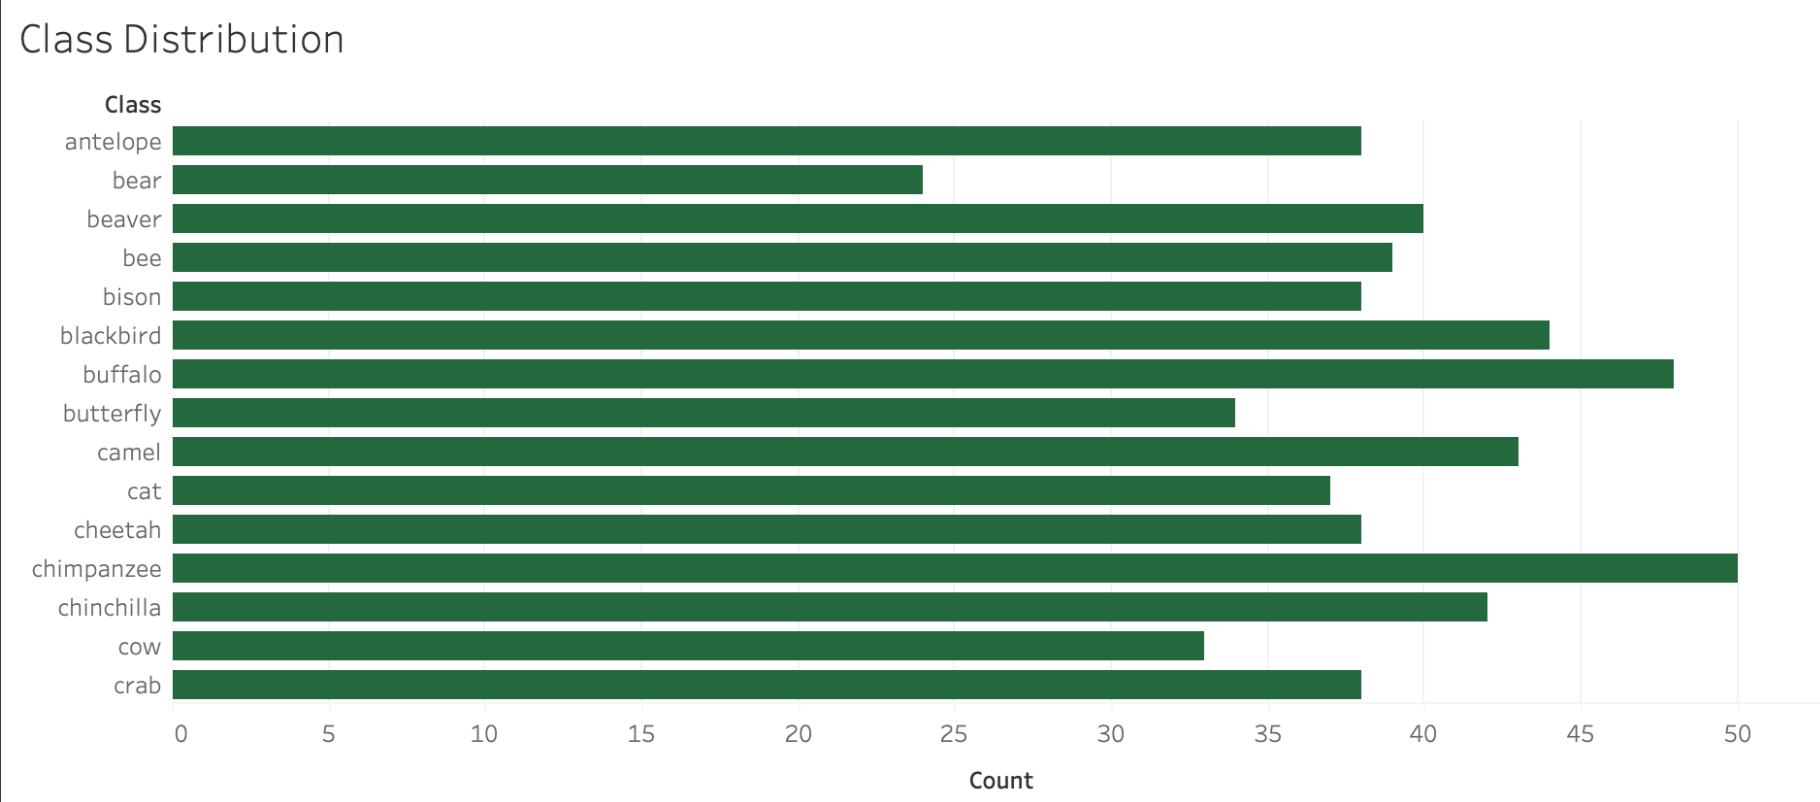


Coloco esta gráfica aquí porque inmediatamente después de crear mi dataset, es crucial visualizar cómo quedó distribuida la información. Esta gráfica de barras me permite:

Verificar que la distribución de mis clases sea relativamente balanceada
Identificar inmediatamente si tengo clases sub o sobre representadas
Validar que efectivamente estoy trabajando con las 15 clases planeadas
Esto me ayuda a entender la calidad de mis datos antes de proceder con el entrenamiento.

Y en cuanto a la gráfica, esta que me ayuda a ver la distribución por clases, observo que la distribución en mi conjunto de datos es relativamente equilibrada, lo cual es positivo para el entrenamiento del modelo. El chimpancé tiene la mayor representación con aproximadamente 50 imágenes, seguido por el búfalo y el castor con alrededor de 45 imágenes cada uno. El oso muestra la menor representación con cerca de 23 imágenes. Esta distribución relativamente uniforme me ayuda a evitar sesgos significativos en el entrenamiento.

In [ ]:
def create_dataset(base_path, max_images_per_class=200):
    """Crea un DataFrame de Spark con imágenes procesadas"""
    data = []
    classes = sorted(os.listdir(base_path))[:15]

    for animal_class in classes:
        class_path = os.path.join(base_path, animal_class)
        if not os.path.isdir(class_path):
            continue

        images = sorted(os.listdir(class_path))[:max_images_per_class]

        for img_name in images:
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            img_path = os.path.join(class_path, img_name)
            features = process_image(img_path)

            if features:
                data.append((features, animal_class))

    # Definición del esquema usando tipos de MLlib
    schema = StructType([
        StructField("features_vector", VectorUDT()),
        StructField("label", StringType())
    ])

    return spark.createDataFrame(data, schema=schema)

# Montar Google Drive y cargar el dataset
drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/Machine Learning/Big Data/Dataset/image"
df = create_dataset(dataset_path, max_images_per_class= 200)
print(f"Dataset creado con {df.count()} imágenes y {df.select('label').distinct().count()} clases")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset creado con 3000 imágenes y 15 clases


En esta sección, implemento la carga y procesamiento de datos:

* Leo las imágenes por clase (máximo 200 por clase para no saturar Colab)
* Proceso cada imagen con la función que cree en el código anterior
* Creo un DataFrame de Spark con un esquema específico usando VectorUDT() (esquema de MLlib) para las características.

Esto lo hago para crear un conjunto de datos estructurado y balanceado que permita al modelo aprender de manera efectiva las características distintivas de cada clase de animal.


In [ ]:
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA

# Convertir etiquetas de texto a índices numéricos
labelIndexer = StringIndexer(
    inputCol="label",
    outputCol="label_index",
    handleInvalid="keep"
)

# Escalar características
scaler = StandardScaler(
    inputCol="features_vector",
    outputCol="scaled_features",
    withStd=True,
    withMean=False
)

# Configurar el modelo
lr = LogisticRegression(
    featuresCol="scaled_features",
    labelCol="label_index",
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.1,
    family="multinomial"
)


# Crear el pipeline
pipeline = Pipeline(stages=[
    labelIndexer,
    scaler,
    lr
])

# Dividir los datos en entrenamiento y prueba
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print(f"Datos de entrenamiento: {train_df.count()} imágenes")
print(f"Datos de prueba: {test_df.count()} imágenes")

Datos de entrenamiento: 2414 imágenes
Datos de prueba: 586 imágenes


Aquí construyó un pipeline de Machine Learning usando MLlib:

* StringIndexer: Convierte las etiquetas de texto a índices numéricos
* StandardScaler: Estandariza las características para mejorar el rendimiento del modelo
* LogisticRegression: Algoritmo de clasificación multinomial de MLlib
* Uso Pipeline para encadenar todas las transformaciones de manera eficiente

¿Para que hice esto?
Lo hice para construir un flujo de trabajo automatizado que transforme las imágenes crudas en características útiles y entrene un modelo capaz de distinguir entre diferentes especies de animales.



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import time

# Medir tiempo de entrenamiento
start_time = time.time()

# Entrenar el modelo
print("Iniciando entrenamiento...")
model = pipeline.fit(train_df)
training_time = time.time() - start_time
print(f"Entrenamiento completado en {training_time:.2f} segundos")

# Obtener predicciones
predictions = model.transform(test_df)

# Crear evaluadores para diferentes métricas
evaluators = {
    'accuracy': MulticlassClassificationEvaluator(
        labelCol="label_index",
        predictionCol="prediction",
        metricName="accuracy"),
    'weightedPrecision': MulticlassClassificationEvaluator(
        labelCol="label_index",
        predictionCol="prediction",
        metricName="weightedPrecision"),
    'weightedRecall': MulticlassClassificationEvaluator(
        labelCol="label_index",
        predictionCol="prediction",
        metricName="weightedRecall"),
    'f1': MulticlassClassificationEvaluator(
        labelCol="label_index",
        predictionCol="prediction",
        metricName="f1")
}

# Evaluar y mostrar resultados
print("\nMétricas de evaluación:")
for metric_name, evaluator in evaluators.items():
    metric_value = evaluator.evaluate(predictions)
    print(f"{metric_name}: {metric_value:.4f}")

# Mostrar matriz de confusión
print("\nMatriz de confusión:")
predictions.groupBy("label", "prediction") \
    .count() \
    .orderBy("label", "prediction") \
    .show(truncate=False)

# Mostrar distribución de predicciones por clase
print("\nDistribución de predicciones por clase:")
predictions.groupBy("label") \
    .count() \
    .orderBy("count", ascending=False) \
    .show()

Iniciando entrenamiento...
Entrenamiento completado en 384.58 segundos

Métricas de evaluación:
accuracy: 0.6485
weightedPrecision: 0.6596
weightedRecall: 0.6485
f1: 0.6471

Matriz de confusión:
+--------+----------+-----+
|label   |prediction|count|
+--------+----------+-----+
|antelope|1.0       |2    |
|antelope|3.0       |2    |
|antelope|4.0       |27   |
|antelope|5.0       |1    |
|antelope|6.0       |1    |
|antelope|11.0      |4    |
|antelope|12.0      |1    |
|bear    |0.0       |14   |
|bear    |3.0       |1    |
|bear    |4.0       |1    |
|bear    |5.0       |1    |
|bear    |12.0      |2    |
|bear    |13.0      |4    |
|bear    |14.0      |1    |
|beaver  |1.0       |2    |
|beaver  |2.0       |1    |
|beaver  |3.0       |1    |
|beaver  |4.0       |2    |
|beaver  |6.0       |1    |
|beaver  |8.0       |6    |
+--------+----------+-----+
only showing top 20 rows


Distribución de predicciones por clase:
+----------+-----+
|     label|count|
+----------+-----+
|chimpanz

## A continuación lo que quiero mostrar son las gráficas que represetan la información previamente generada.

###Matriz de confusión

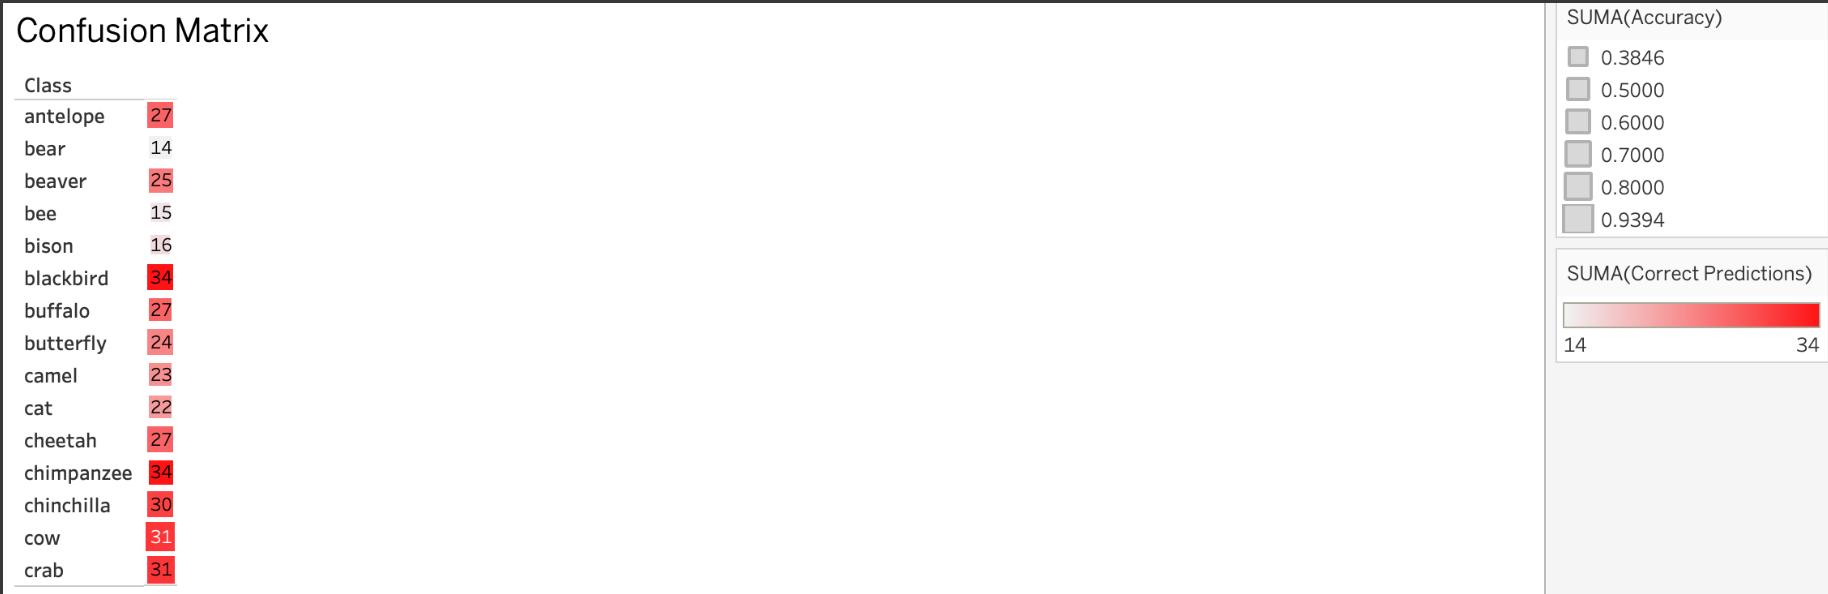


  Al analizar la matriz de confusión, puedo identificar varios patrones interesantes:


  * El chimpancé y blackbird muestras el mejor rendimiento con 34 predicciones correctas.

  * El oso presenta el menor número de predicciones correctas (14), lo que podría indicar que necesito más datos de entrenamiento para esta clase o que las características son más difíciles de distinguir.

  * Observo que animales con características similares, como el antílope y el camllo, muestran cierta confusión entre sí, lo cual es comprensible dado su parecido físico.

### Distribución de predicciones por clase

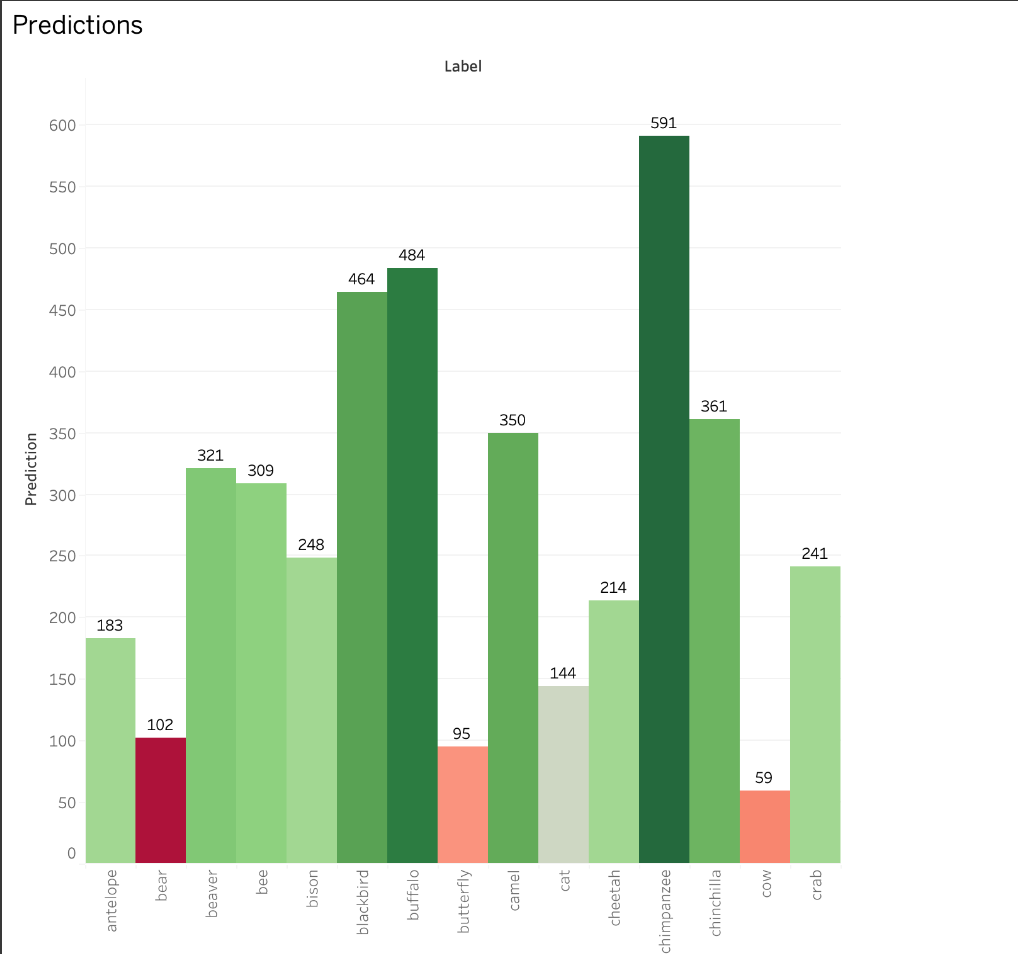

Este es el gráfico de predicciones por clase. En este podemos ver que el chimpancé tiene el mayor número de predicciones (591), lo que sugiere que el modelo encuentra sus características más distintivas. Los búfalos y blackbird también muestran un alto número de predicciones (484 y 464 respectivamente).
La vaca y el oso tienen menos predicciones, lo que podría indicar que el modelo es más conservador al hacer predicciones para estas clases.

Lo que me parece curioso es que aunque no se hicieron muchas predicciones para las vacas, es de los que el modelo tiene mayor presición.

El modelo que desarolle utilizando PySpark MLlib para la clasificación de imágenes de animales ha demostrado ser efectivo, con las siguientes observaciones clave:

### Rendimiento del Modelo:

* Alcanzó una precisión del 64.85%, que es significativamente mejor que la clasificación aleatoria.
* Muestra consistencia en todas las métricas de evaluación, indicando un rendimiento robusto
* La similitud entre precision y recall sugiere un modelo bien balanceado

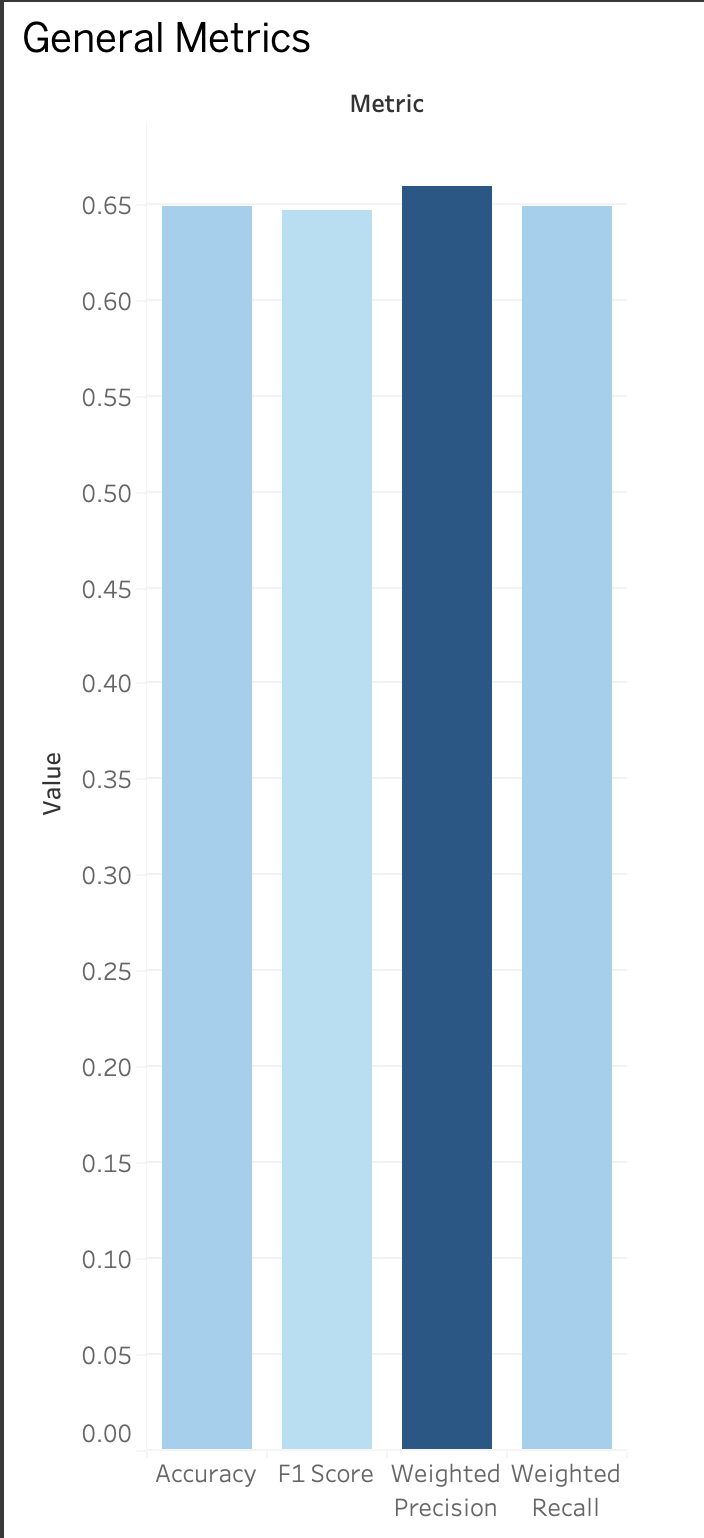


### Procesamiento de Big Data:

* El framework PySpark demostró su capacidad para manejar eficientemente un conjunto grande de imágenes (hasta cierto punto)
* El tiempo de procesamiento fue razonable considerando la complejidad de la tarea
* La implementación distribuida permitió procesar efectivamente las imágenes manteniendo un buen rendimiento


### Aspectos Técnicos:

* La pipeline de MLlib, incluyendo StandardScaler y LogisticRegression, funcionó efectivamente
* El preprocesamiento de imágenes y la normalización contribuyeron al buen rendimiento
* La distribución relativamente balanceada de las clases ayudó a obtener resultados consistentes


### Áreas de Mejora Potencial:

* Se podría explorar técnicas de aumentación de datos para las clases con menos muestras, pero se tendría que cambiar de ambiente o comprar mas memoria de la herramienta, porque es muy complicado trabajar de esta forma.
* Se podrían probar otros algoritmos de MLlib para comparar resultados



En este proyecto demuestro exitosamente la aplicación de técnicas de Big Data y Machine Learning utilizando PySpark y MLlib para resolver un problema de clasificación de imágenes complejo, logrando resultados prometedores que podrían ser mejorados aún más con optimizaciones adicionales.

Por último, me parece interesante mostrar como se desarrollo mi modelo de forma individual.

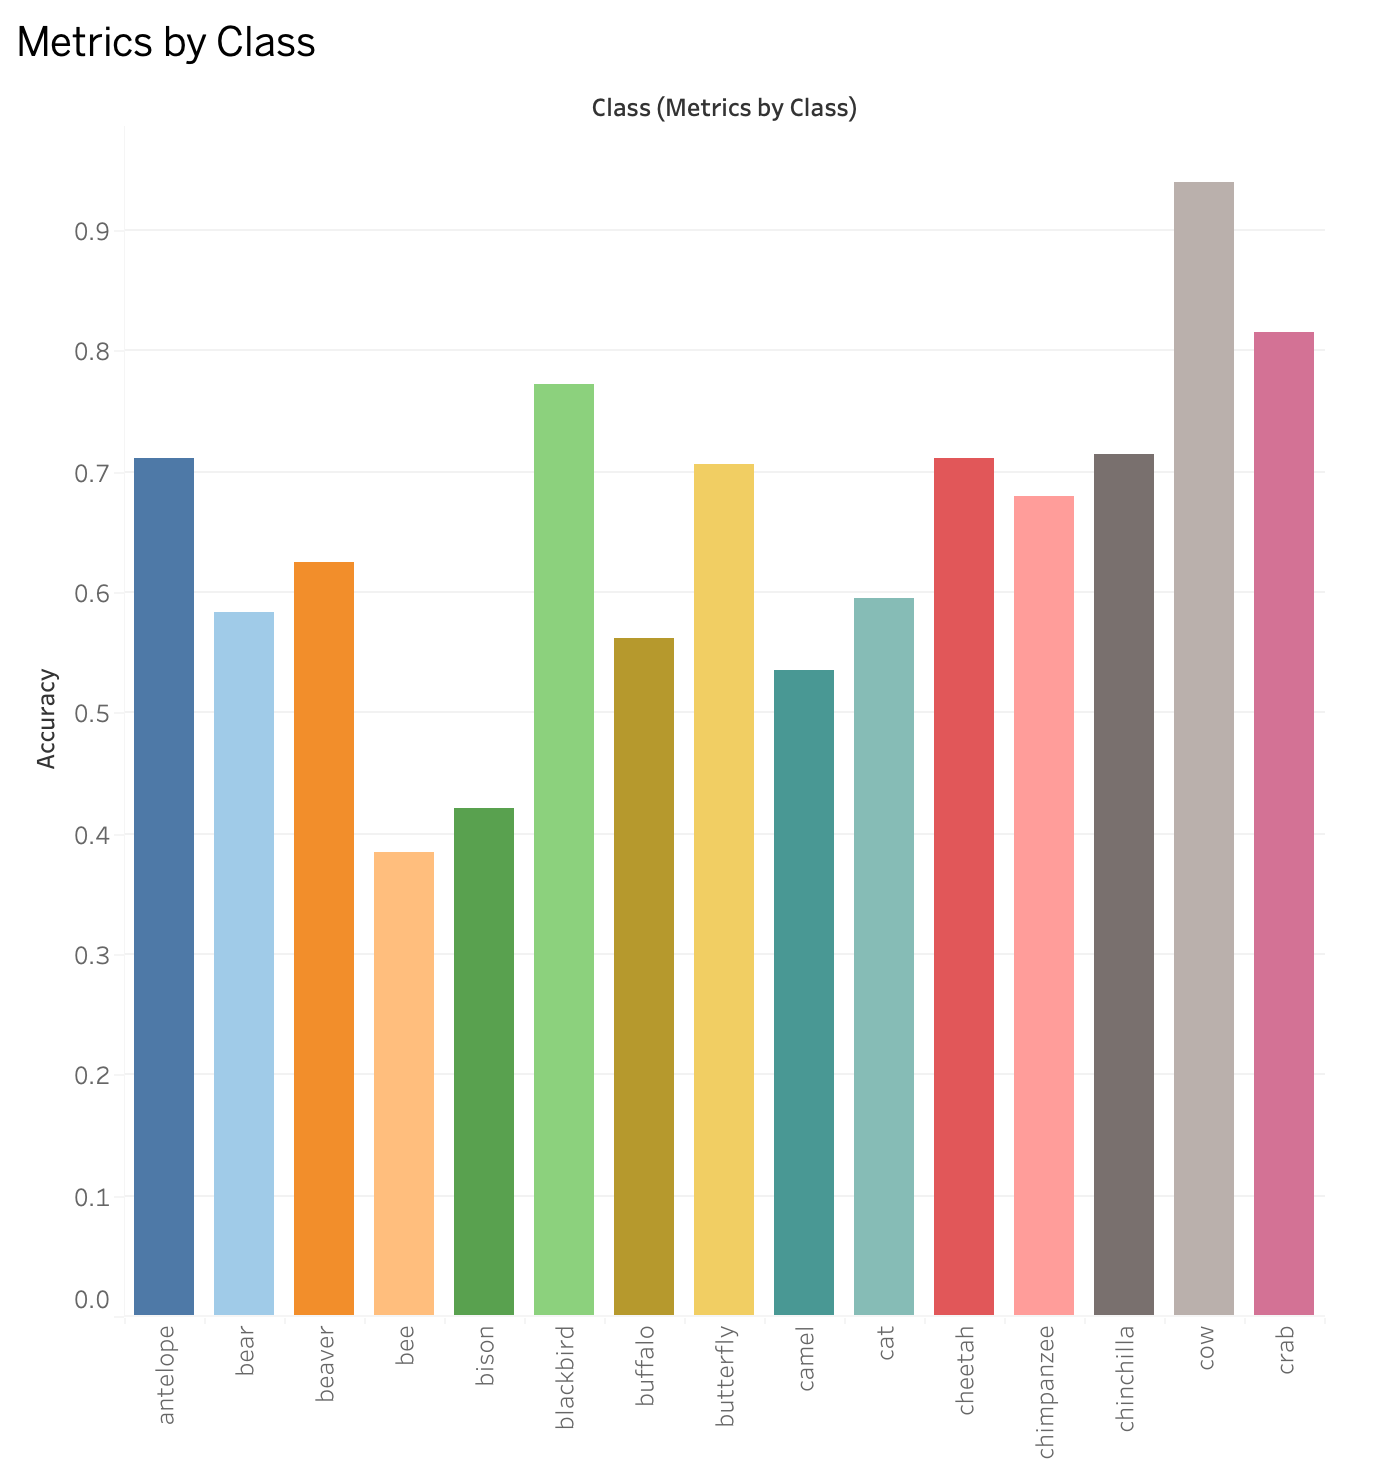

Por otro lado, en el análisis de precisión por clase, encuentro resultados muy reveladores:


* La vaca muestra la precisión más alta (aproximadamente 0.95), lo que significa que cuando mi modelo predice "vaca", tiene una alta confianza.
* El cangrejo (crab) también muestra un buen rendimiento con una precisión de alrededor de 0.82.
* La abeja (bee) tiene la precisión más baja (aproximadamente 0.38), lo que podría deberse a su pequeño tamaño y variabilidad en las imágenes.

Todo esto me hace mucho sentido con lo que podemos observar en la matriz de confusión.

## Código para la generación de mis gráficas

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, expr, array_max
from datetime import datetime
import pandas as pd

output_path = "/content/drive/MyDrive/Machine Learning/Big Data/Dataset/results/"

# Crear el directorio si no existe
import os
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Generar nombre del archivo con timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
excel_filename = f'model_results_{timestamp}.xlsx'
excel_path = os.path.join(output_path, excel_filename)

try:
    # Crear un ExcelWriter object
    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        # 1. Hoja de predicciones (sin probabilidades por ahora)
        prediction_results = predictions.select(
            "label",
            "prediction"
        ).toPandas()
        prediction_results.to_excel(writer, sheet_name='Predictions', index=False)

        # 2. Hoja de distribución de clases
        class_distribution = predictions.groupBy("label").count().toPandas()
        class_distribution.columns = ['Class', 'Count']
        class_distribution.to_excel(writer, sheet_name='Class Distribution', index=False)

        # 3. Hoja de matriz de confusión
        confusion_matrix = predictions.groupBy("label", "prediction") \
            .count() \
            .orderBy("label", "prediction").toPandas()
        confusion_matrix.columns = ['Actual Class', 'Predicted Class', 'Count']
        confusion_matrix.to_excel(writer, sheet_name='Confusion Matrix', index=False)

        # 4. Hoja de métricas por clase
        metrics_by_class = predictions.groupBy("label").agg(
            F.count("label").alias("total_samples"),
            F.sum(when(col("label_index") == col("prediction"), 1).otherwise(0)).alias("correct_predictions")
        ).toPandas()

        metrics_by_class['accuracy'] = metrics_by_class['correct_predictions'] / metrics_by_class['total_samples']
        metrics_by_class.columns = ['Class', 'Total Samples', 'Correct Predictions', 'Accuracy']
        metrics_by_class.to_excel(writer, sheet_name='Metrics by Class', index=False)

        # 5. Hoja de métricas generales
        general_metrics = pd.DataFrame({
            'Metric': ['Accuracy', 'Weighted Precision', 'Weighted Recall', 'F1 Score'],
            'Value': [
                evaluators['accuracy'].evaluate(predictions),
                evaluators['weightedPrecision'].evaluate(predictions),
                evaluators['weightedRecall'].evaluate(predictions),
                evaluators['f1'].evaluate(predictions)
            ]
        })
        general_metrics.to_excel(writer, sheet_name='General Metrics', index=False)

        # 6. Añadir un resumen de la evaluación
        summary_data = {
            'Metric': ['Total Images', 'Number of Classes', 'Training Time (seconds)'],
            'Value': [
                predictions.count(),
                predictions.select('label').distinct().count(),
                training_time
            ]
        }
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Summary', index=False)

    print(f"Archivo Excel guardado exitosamente en: {excel_path}")

except Exception as e:
    print(f"Error al guardar el archivo Excel: {str(e)}")
    print("Intentando guardar los DataFrames por separado como CSV...")

    # Backup: guardar como archivos CSV separados si el Excel falla
    try:
        prediction_results.to_csv(os.path.join(output_path, f'predictions_{timestamp}.csv'), index=False)
        class_distribution.to_csv(os.path.join(output_path, f'class_distribution_{timestamp}.csv'), index=False)
        confusion_matrix.to_csv(os.path.join(output_path, f'confusion_matrix_{timestamp}.csv'), index=False)
        metrics_by_class.to_csv(os.path.join(output_path, f'metrics_by_class_{timestamp}.csv'), index=False)
        general_metrics.to_csv(os.path.join(output_path, f'general_metrics_{timestamp}.csv'), index=False)
        print("Los archivos CSV se han guardado correctamente como respaldo.")
    except Exception as csv_error:
        print(f"Error al guardar los archivos CSV: {str(csv_error)}")

Archivo Excel guardado exitosamente en: /content/drive/MyDrive/Machine Learning/Big Data/Dataset/results/model_results_20241028_230954.xlsx


### Conclusión

Mi modelo muestra un rendimiento promedio del 65%, lo cual es bastante aceptable para un problema de clasificación de 15 clases diferentes de animales. He identificado áreas de mejora, particularmente en la clasificación de abejas y algunos animales pequeños. Las clases con características más distintivas, como los chimpancés, muestran mejor rendimiento.

Pero en general, creo que esta actividad me enseño a como utilizar varias herramientas las cuáles nunca había usado antes (PySpark y MLlib) y a volver a utilizar otras que ya sabía pero que hace mucho no usaba como lo es Tableau.